## DC Overview

*What do you want to learn from the data?*
Want to know "whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell"


*How will we 'ingest' the data?*
Things to think about: "how can you best explore the data? Why did you select your particular model? How did you validate your model? What insights can you derive from your results?"



## Exploration Phase

[Data](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data) has 699 cells with these features:

Sample code number: id number

Clump Thickness: 1 - 10

Uniformity of Cell Size: 1 - 10

Uniformity of Cell Shape: 1 - 10

Marginal Adhesion: 1 - 10

Single Epithelial Cell Size: 1 - 10

Bare Nuclei: 1 - 10

Bland Chromatin: 1 - 10

Normal Nucleoli: 1 - 10

Mitoses: 1 - 10

Class: (2 for benign, 4 for malignant)





In [1]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
pd.options.display.max_columns = 25

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


# Intro and choice of the metric

Because we want to assess whether or not a cell falls into one category or another cateory, we are going to use a classifier. 

An early consensus is to use a Random Forest Classifier to classify 'benign' and 'malignant' because it will work with most distributions of data. We will also compare this to a logistic regression, an SVM and Gradient Boosting Classifier to gauge performance.

Overall, the goal is to have a classifier that minimizes false negatives (i.e. telling someone their cell is NOT cancerous when it actually IS). Our outputs here are telling us about the ability of our model to identify ALL relevant instances (recall) and its ability to return ONLY relevant instances (precision). F1 is a metric that combines recall and precision using the harmonic mean.

In [26]:
df = pd.read_csv('breast-cancer-wisconsin.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [27]:
df.columns = ['id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitosis', 'class']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                        699 non-null int64
clump_thickness           699 non-null int64
uniformity_cell_size      699 non-null int64
uniformity_cell_shape     699 non-null int64
marginal_adhesion         699 non-null int64
single_epithelial_size    699 non-null int64
bare_nuclei               699 non-null object
bland_chromatin           699 non-null int64
normal_nucleoli           699 non-null int64
mitosis                   699 non-null int64
class                     699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


/Users/michellelee/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


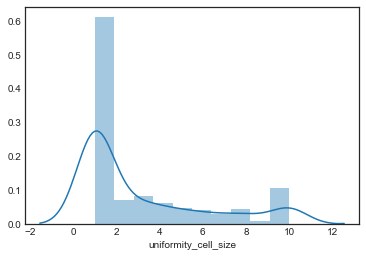

In [28]:
#Data Visualization
sns.distplot(df['uniformity_cell_size'])

/Users/michellelee/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


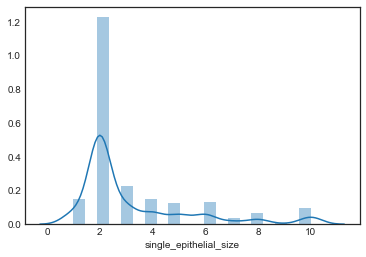

In [29]:
sns.distplot(df['single_epithelial_size'])

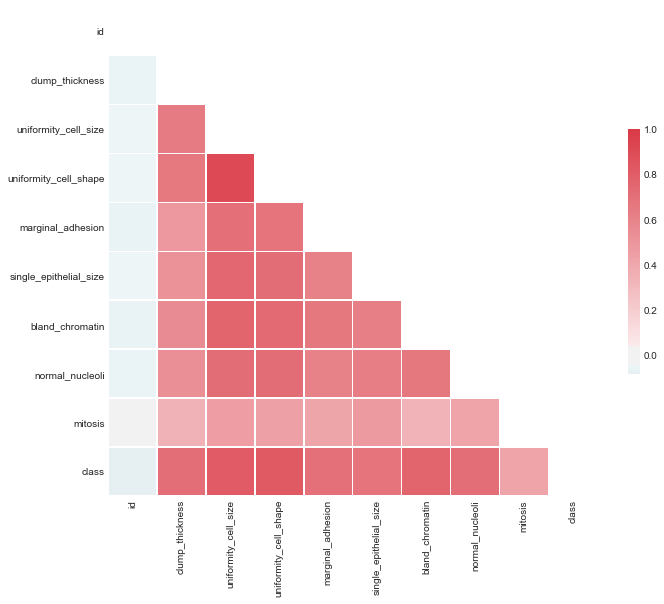

In [30]:
corr = df.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Figure size 864x504 with 0 Axes>

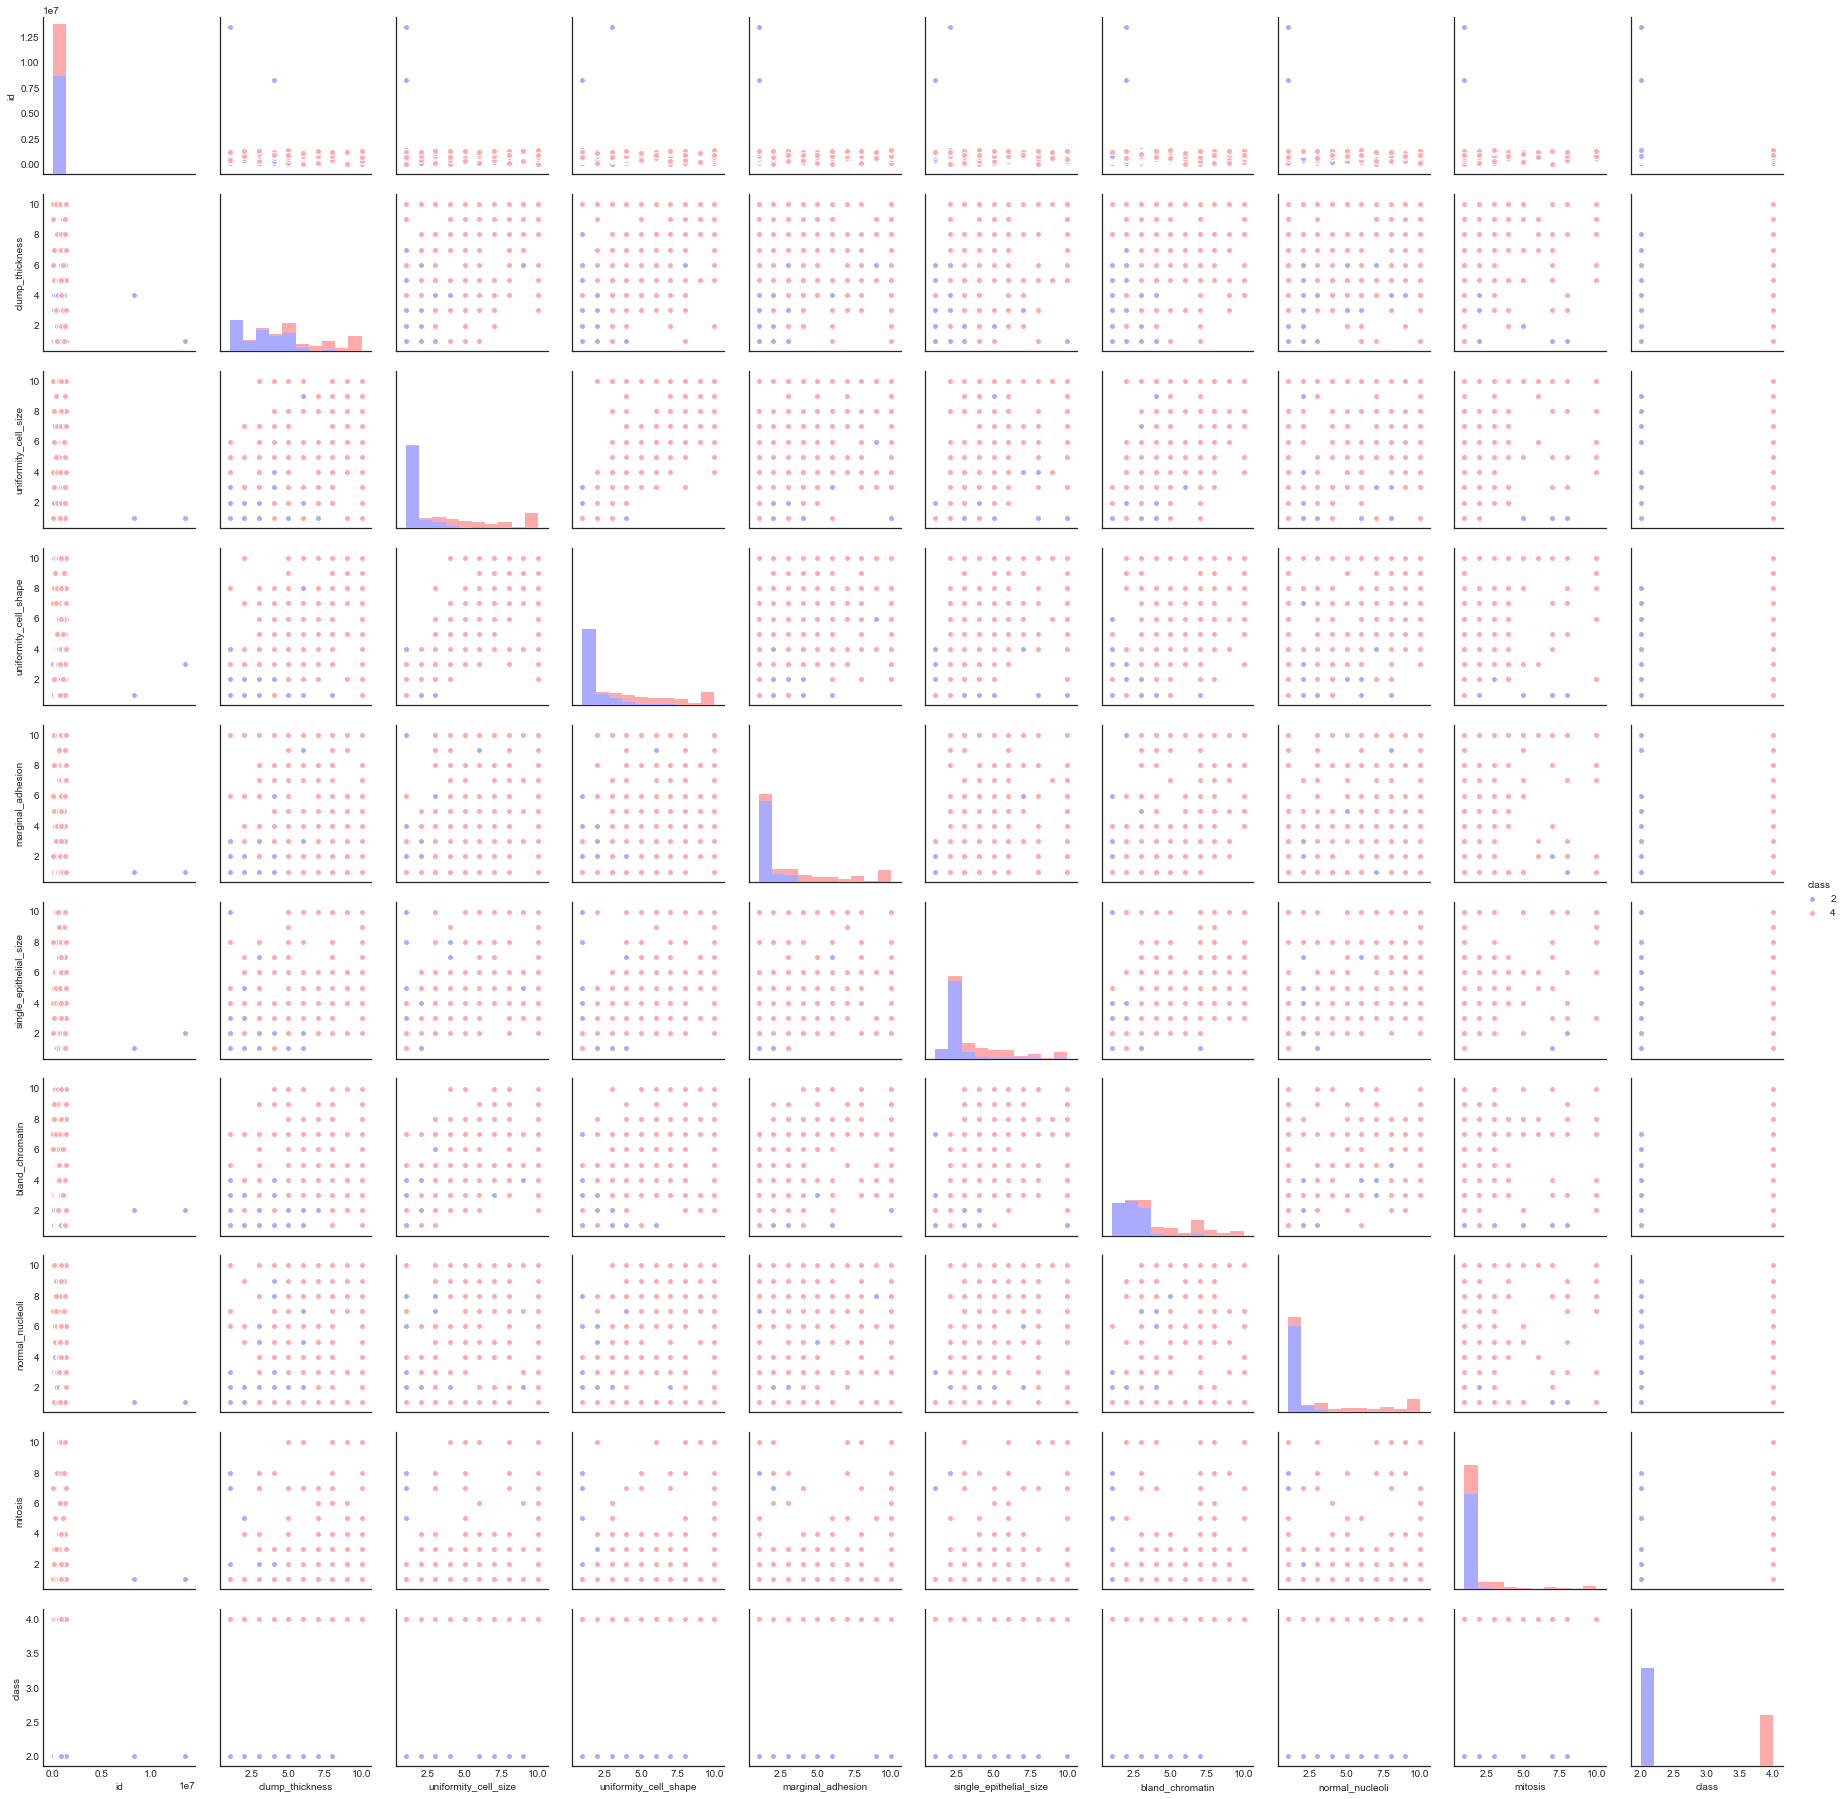

In [31]:
plt.figure(figsize=(12,7))
sns.pairplot(df,hue='class',palette='bwr')

In [32]:
#Data Cleaning Steps
#1. Replaced 2 and 4 with 0 and 1
df['class'] = df['class'].map({2:0, 4:1})
y = df['class']

#2. Replaced ? in bare_nuclei column with Nan
df['bare_nuclei'].replace('?', np.NaN, inplace=True)
df.head()

,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


We have missing values, which we want to deal with. We could just delete them from our dataset, but that might not be the best idea because that data might have other data points that bring valuable information to our classifier. To avoid just dropping these empty values, we can use *imputation*. There are a couple of things we can do to impute things -- we can take the mean of other values in the column to 'guess' what our missing values might be, or cluster them together based on other attributes of our data and assess what their value might be that way. 

In [33]:
#Data Imputation
#Used fancyimpute KNN to impute Nan with values corresponding to the 3 nearest neighbors
# df_filled = df.pop('class')
# df_filled.as_matrix()
# df_filled = pd.DataFrame(KNN(3).complete(df))

# We have missing values so we want to impute
# We will use KNN method to do this from fancyimpute library
# Never mind, let's just use mean imputer
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy="median", axis=0)
df["bare_nuclei"] = imp.fit_transform(df[["bare_nuclei"]]).ravel()
df_filled = df

We tried KNN imputation from fancyimpute, but found that we needed to standardize our data to mean=0, sd=1. We ultimately decided to impute with means.

In [34]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                        699 non-null int64
clump_thickness           699 non-null int64
uniformity_cell_size      699 non-null int64
uniformity_cell_shape     699 non-null int64
marginal_adhesion         699 non-null int64
single_epithelial_size    699 non-null int64
bare_nuclei               699 non-null float64
bland_chromatin           699 non-null int64
normal_nucleoli           699 non-null int64
mitosis                   699 non-null int64
class                     699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.1 KB


In [40]:
df_filled.head()

,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0


In [41]:
y = df_filled.pop('class')
X = df_filled

# train-test split and algorithm comparison
In this section we:
  1) separated the independent variables (features) and dependent variable into X and y.
  2) split both X and y into training and testing sets using 80% to 20% ratio. 
  3) we tested 3 different classifier models: SVM, Logistic Regression and Random Forest. 

From the results we can see that Random Forest out performed both SVM and Logistic Regression in all metrics: accuracy, recall and F1 score.
This can be due to the fact that both SVM and LogReg are linear classifiers and RandomForest can deal with non-linear classification problems. Also Random Forest can deal with both categorical or numerical variables.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [56]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82        98
          1       0.00      0.00      0.00        42

avg / total       0.49      0.70      0.58       140

[[98  0]
 [42  0]]


/Users/michellelee/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
SVMmodel = SVC()
SVMmodel.fit(X_train,y_train)
predictions = SVMmodel.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82        98
          1       0.00      0.00      0.00        42

avg / total       0.49      0.70      0.58       140

[[98  0]
 [42  0]]


/Users/michellelee/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96        98
          1       0.90      0.90      0.90        42

avg / total       0.94      0.94      0.94       140

[[94  4]
 [ 4 38]]


# hyperparameter search using GridSearchCV
Random forest model has two main hyper parameters that can be tuned to improve the performance of the classifier, which are n_estimators and max_depth.

'n_estimators' decides how many trees you want in the forest: for example, if n_estimators = 1, it will be identical to a single decision tree with subset of data. With higher n_estimators RF will be more resilient to overfitting, which is the biggest problem of decision tree, but the memory usage will be linearly proportional to n_estimators, so after a threshold value, increasing n_estimators does not help improve the performance of the model.

'max_depth' determines how many decisions you want to make when splitting the data. For example, for a perfectly balanced binary tree of depth n, the number of decisions will be 2^n-1, so depending on how complicated the problem is, the depth of the tree should increase accordingly. However, if the depth is too high, there is a chance that the forest will overfit.

sklearn.GridSearchCV enables automated hyper parameter search by creating a grid of given hyperparameters arrays. It runs the model on all the possible combinations of hyper parameters given wich desired k-fold cross validation data (the default is 3?), and returns the score (~metric) of the model based on the choice of  'scoring' parameter. We chose F1 as our metric as we wanted to minimize the false negative cases.

As a result we find n_estimators = 100 and max_depth = 5 returns the best result where the number of FN is 1.

In [49]:
#Based on best performance, conducted grid search on random forest 
param_grid = {'n_estimators': [10, 50, 100, 500],
              'max_depth': [5,10,50],
              'random_state': [1, None]
              }
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3, scoring='f1')
grid.fit(X_train,y_train)
grid.best_params_

best_rf_model = grid.best_estimator_
best_rf_model.fit(X_train, y_train)
best_rf_preds = best_rf_model.predict(X_test)
print(confusion_matrix(y_test, best_rf_preds))
print(classification_report(y_test,best_rf_preds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=5, n_estimators=10, random_state=1 ....................
[CV]  max_depth=5, n_estimators=10, random_state=1, score=0.9624060150375939, total=   0.0s
[CV] max_depth=5, n_estimators=10, random_state=1 ....................
[CV]  max_depth=5, n_estimators=10, random_state=1, score=0.962962962962963, total=   0.0s
[CV] max_depth=5, n_estimators=10, random_state=1 ....................
[CV]  max_depth=5, n_estimators=10, random_state=1, score=0.9393939393939394, total=   0.0s
[CV] max_depth=5, n_estimators=10, random_state=None .................
[CV]  max_depth=5, n_estimators=10, random_state=None, score=0.9538461538461538, total=   0.0s
[CV] max_depth=5, n_estimators=10, random_state=None .................
[CV]  max_depth=5, n_estimators=10, random_state=None, score=0.962962962962963, total=   0.0s
[CV] max_depth=5, n_estimators=10, random_state=None .................
[CV]  max_depth=5, n_estimators=10, random_state=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=5, n_estimators=50, random_state=1, score=0.9696969696969696, total=   0.1s
[CV] max_depth=5, n_estimators=50, random_state=1 ....................
[CV]  max_depth=5, n_estimators=50, random_state=1, score=0.9705882352941176, total=   0.1s
[CV] max_depth=5, n_estimators=50, random_state=1 ....................
[CV]  max_depth=5, n_estimators=50, random_state=1, score=0.9558823529411765, total=   0.1s
[CV] max_depth=5, n_estimators=50, random_state=None .................
[CV]  max_depth=5, n_estimators=50, random_state=None, score=0.9538461538461538, total=   0.1s
[CV] max_depth=5, n_estimators=50, random_state=None .................
[CV]  max_depth=5, n_estimators=50, random_state=None, score=0.9558823529411765, total=   0.1s
[CV] max_depth=5, n_estimators=50, random_state=None .................
[CV]  max_depth=5, n_estimators=50, random_state=None, score=0.9635036496350364, total=   0.1s
[CV] max_depth=5, n_estimators=100, random_state=1 ...................
[CV]  max_dep

[CV]  max_depth=50, n_estimators=50, random_state=1, score=0.9558823529411765, total=   0.1s
[CV] max_depth=50, n_estimators=50, random_state=None ................
[CV]  max_depth=50, n_estimators=50, random_state=None, score=0.9696969696969696, total=   0.1s
[CV] max_depth=50, n_estimators=50, random_state=None ................
[CV]  max_depth=50, n_estimators=50, random_state=None, score=0.9705882352941176, total=   0.1s
[CV] max_depth=50, n_estimators=50, random_state=None ................
[CV]  max_depth=50, n_estimators=50, random_state=None, score=0.9558823529411765, total=   0.1s
[CV] max_depth=50, n_estimators=100, random_state=1 ..................
[CV]  max_depth=50, n_estimators=100, random_state=1, score=0.9618320610687023, total=   0.2s
[CV] max_depth=50, n_estimators=100, random_state=1 ..................
[CV]  max_depth=50, n_estimators=100, random_state=1, score=0.9705882352941176, total=   0.2s
[CV] max_depth=50, n_estimators=100, random_state=1 ..................
[CV] 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   25.5s finished


[[94  4]
 [ 4 38]]
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        98
          1       0.90      0.90      0.90        42

avg / total       0.94      0.94      0.94       140



In [53]:
grid.best_params_

{'max_depth': 5, 'n_estimators': 100, 'random_state': None}

In [54]:
ada_boost_grid = {'n_estimators': [50, 100, 150, 200],
                      'random_state': [1, None],
                      'learning_rate': [0.1, .5, 1]}

ada_gridsearch = GridSearchCV(AdaBoostClassifier(),
                             ada_boost_grid,
                             n_jobs=-1,
                             verbose=True)
ada_gridsearch.fit(X_train, y_train)

best_ada_model = ada_gridsearch.best_estimator_
best_ada_model.fit(X_train, y_train)
best_ada_preds = best_ada_model.predict(X_test)

print(confusion_matrix(y_test, best_ada_preds))
print(classification_report(y_test,best_ada_preds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    9.6s finished


[[94  4]
 [ 3 39]]
             precision    recall  f1-score   support

          0       0.97      0.96      0.96        98
          1       0.91      0.93      0.92        42

avg / total       0.95      0.95      0.95       140



In [55]:
gradient_boost_grid = {'n_estimators': [50, 100, 150, 200],
                      'random_state': [1, None],
                      'learning_rate': [0.1, .5, 1]}

gdr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gradient_boost_grid,
                             n_jobs=-1,
                             verbose=True)
gdr_gridsearch.fit(X_train, y_train)

best_gdr_model = gdr_gridsearch.best_estimator_
best_gdr_model.fit(X_train, y_train)
best_gdr_preds = best_gdr_model.predict(X_test)
print(confusion_matrix(y_test, best_gdr_preds))
print(classification_report(y_test,best_gdr_preds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    3.6s finished


[[93  5]
 [ 4 38]]
             precision    recall  f1-score   support

          0       0.96      0.95      0.95        98
          1       0.88      0.90      0.89        42

avg / total       0.94      0.94      0.94       140



## Conclusion

In conclusion, we found that random forest, gradient boosting, and ada boost had similar performance with regard to recall and F1 score (94-95%). Since random forest is computationally less expensive, we would recommend using a random forest model with max depth of 5 and 100 estimators.